In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

position_info = pd.read_pickle("/Users/edeno/Downloads/Jaq_03_16_position_info.pkl")
spikes = pd.read_pickle("/Users/edeno/Downloads/Jaq_03_16_spikes.pkl")
is_ripple = pd.read_pickle("/Users/edeno/Downloads/Jaq_03_16_is_ripple.pkl")

spikes = np.asarray(spikes)
position = np.asarray(position_info.linear_position)

In [2]:
from replay_trajectory_classification.classifier import joblib

env = joblib.load("/Users/edeno/Downloads/Jaq_03_16_environment.pkl")

Cupy is not installed or GPU is not detected. Ignore this message if not using GPU


In [3]:
from replay_trajectory_classification import RandomWalk, Environment, Uniform, Environment

random_walk = RandomWalk().make_state_transition([env])
uniform = Uniform().make_state_transition([env])

In [4]:
from patsy import DesignInfo, DesignMatrix, build_design_matrices, dmatrix
import numpy as np
from scipy.optimize import minimize

import jax
import jax.numpy as jnp

from sklearn import linear_model

def fit_regression(design_matrix, weights, spikes, position):

    @jax.jit
    def neglogp(
        coefficients, spikes=spikes, design_matrix=design_matrix, weights=weights
    ):
        conditional_intensity = jnp.exp(design_matrix @ coefficients)
        conditional_intensity = jnp.clip(conditional_intensity, a_min=1e-15, a_max=None)
        log_likelihood = weights * jax.scipy.stats.poisson.logpmf(
            spikes.astype(float), conditional_intensity
        )
        return -log_likelihood.sum()

    dlike = jax.grad(neglogp)
    dlike2 = jax.hessian(neglogp)
    
    initial_condition = np.array([np.log(np.average(spikes, weights=weights))])
    initial_condition = np.concatenate([initial_condition, np.zeros(design_matrix.shape[1] - 1)])

    res = minimize(
        neglogp, x0=initial_condition, method="Newton-CG", jac=dlike, hess=dlike2
    )

    return res.x

def fit_regression_regularized(design_matrix, weights, spikes, position, penalty=0.0):

    @jax.jit
    def neglogp(
        coefficients, spikes=spikes, design_matrix=design_matrix, weights=weights
    ):
        conditional_intensity = jnp.exp(design_matrix @ coefficients)
        conditional_intensity = jnp.clip(conditional_intensity, a_min=1e-15, a_max=None)
        log_likelihood = weights * jax.scipy.stats.poisson.logpmf(
            spikes.astype(float), conditional_intensity
        )
        return -log_likelihood.mean() + penalty * (coefficients[1:] @ coefficients[1:].T)

    dlike = jax.grad(neglogp)
    dlike2 = jax.hessian(neglogp)
    
    initial_condition = np.array([np.log(np.average(spikes, weights=weights))])
    initial_condition = np.concatenate([initial_condition, np.zeros(design_matrix.shape[1] - 1)])

    res = minimize(
        neglogp, x0=initial_condition, method="Newton-CG", jac=dlike, hess=dlike2
    )

    return res.x

def make_spline_predict_matrix(
    design_info: DesignInfo, place_bin_centers: np.ndarray
) -> DesignMatrix:
    """Make a design matrix for position bins"""
    predict_data = {}
    predict_data[f"x"] = place_bin_centers
        
    return build_design_matrices([design_info], predict_data)[0]

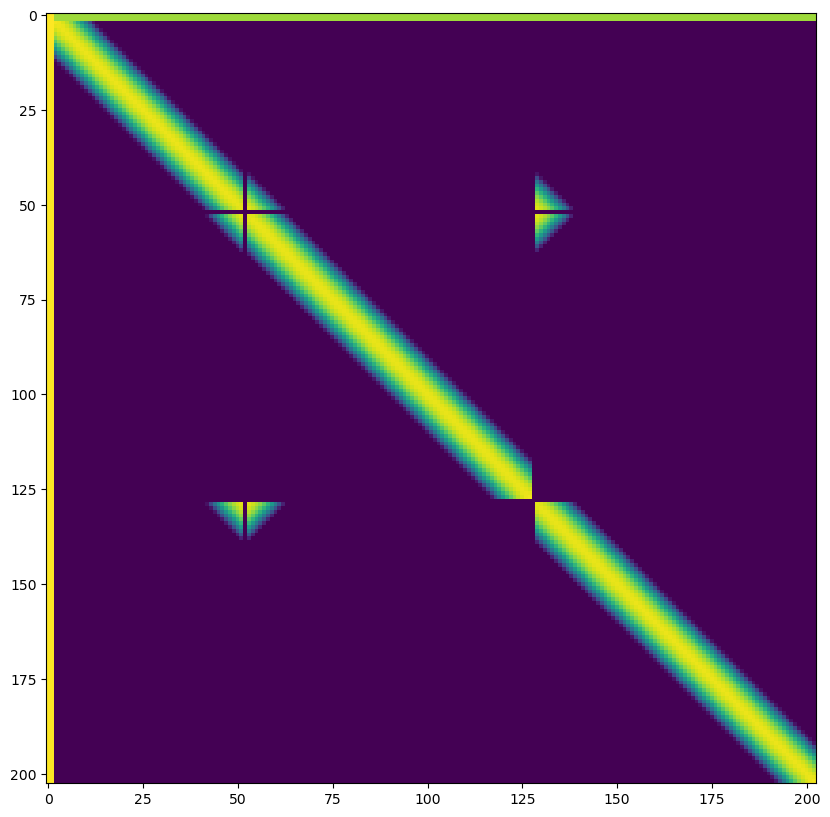

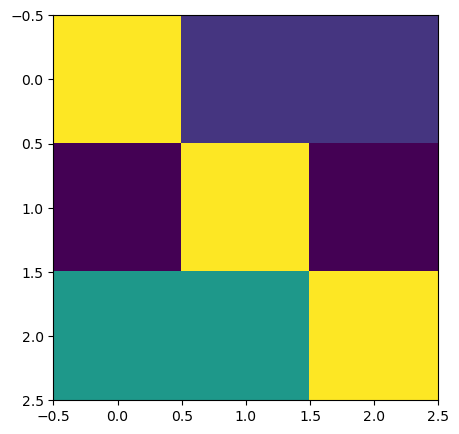

In [5]:
from src.hmm import (
    viterbi,
    check_converged,
    poisson_log_likelihood
)
from src.hmm3 import forward, smoother, estimate_transition_matrix
from tqdm.autonotebook import tqdm

tolerance = 1e-4
max_iter = 3

data_log_likelihoods = []
n_iter = 0
converged = False

# local, no spike, continuous

n_states = 3
n_env_bins = env.place_bin_centers_.shape[0]
bin_sizes = [1, 1, n_env_bins]

state_ind = np.concatenate([ind * np.ones((bin_size,), dtype=int) for ind, bin_size in enumerate(bin_sizes)])
n_state_bins = len(state_ind)

initial_conditions = np.zeros((n_state_bins,))
initial_conditions[state_ind == 0] = 1.0


is_training = ~np.asarray(is_ripple).copy().squeeze()

local_to_local_prob = (is_training[:-1] & is_training[1:]).sum() / is_training[:-1].sum()

discrete_state_transitions = np.asarray([[local_to_local_prob,   (1-local_to_local_prob)/2, (1-local_to_local_prob)/2],
                                         [0.0001/2, 0.9999,   0.0001/2],
                                         [0.02/2,   0.02/2,   0.98],
                                         ])
discrete_state_transitions_per_bin = discrete_state_transitions[np.ix_(state_ind, state_ind)]

continuous_state_transitions = np.zeros((n_state_bins, n_state_bins))

# need to zero out transitions to invalid position bins?
for from_state in range(n_states):
    for to_state in range(n_states):
        inds = np.ix_(state_ind==from_state, state_ind==to_state)
        
        if (bin_sizes[from_state] == 1) & (bin_sizes[to_state] == 1):
            # transition from discrete to discrete
            continuous_state_transitions[inds] = 1.0
        elif (bin_sizes[from_state] > 1) & (bin_sizes[to_state] == 1):
            # transition from continuous to discrete
            continuous_state_transitions[inds] = 1.0
        elif (bin_sizes[from_state] == 1) & (bin_sizes[to_state] > 1):
            # transition from discrete to continuous
            continuous_state_transitions[inds] = 1.0 / bin_sizes[to_state] # uniform
        else:
            # transition from continuous to continuous
            if from_state != to_state:
                continuous_state_transitions[inds] = 1.0 / bin_sizes[to_state] # uniform
            else:
                continuous_state_transitions[inds] = random_walk.copy()
                

n_time = spikes.shape[0]
causal_state_probabilities = np.zeros((n_time, n_states))
acausal_state_probabilities = np.zeros((n_time, n_states))
predictive_state_probabilities = np.zeros((n_time, n_states))

sampling_frequency = 500

df = 15
data = {"x": position}
design_matrix = dmatrix(f"bs(x, df={df})", data)
zero_rates = np.ones_like(spikes) * 1e-5 / sampling_frequency
predict_matrix = make_spline_predict_matrix(design_matrix.design_info, env.place_bin_centers_)


plt.figure(figsize=(10, 10))
plt.imshow(np.log(continuous_state_transitions + np.spacing(1)))


plt.figure(figsize=(5, 5))
plt.imshow(np.log(discrete_state_transitions + np.spacing(1)))


In [6]:
fit_likelihood = True
fit_inital_conditions = False
fit_discrete_transition = False

coefficients_iter = []
local_rates_iter = []
non_local_rates_iter = []
is_training_iter = []
acausal_posterior_iter = []

while not converged and (n_iter < max_iter):
    
    # Likelihoods
    print("Likelihoods")
    if np.logical_or(n_iter == 0, fit_likelihood):
        coefficients = np.stack([fit_regression(design_matrix, is_training.astype(float), s, position) for s in tqdm(spikes.T)], axis=1)

        local_rates = np.exp(design_matrix @ coefficients)

        log_likelihood = np.zeros((n_time, n_state_bins))
        log_likelihood[:, state_ind==0] = np.sum(poisson_log_likelihood(spikes, local_rates), axis=-1)[:, np.newaxis]
        log_likelihood[:, state_ind==1] = np.sum(poisson_log_likelihood(spikes, zero_rates), axis=-1)[:, np.newaxis]

        non_local_rates = np.exp(predict_matrix @ coefficients)
        for s, r in zip(spikes.T, non_local_rates.T):
            log_likelihood[:, state_ind==2] += poisson_log_likelihood(s[:, np.newaxis], r[np.newaxis])
    
    
    coefficients_iter.append(coefficients)
    local_rates_iter.append(local_rates)
    non_local_rates_iter.append(non_local_rates)
    is_training_iter.append(is_training.astype(float))
    
    discrete_state_transitions_per_bin = discrete_state_transitions[np.ix_(state_ind, state_ind)]

    transition_matrix = discrete_state_transitions_per_bin * continuous_state_transitions

    # Expectation step
    print("Expectation Step")
    causal_posterior, predictive_distribution, marginal_log_likelihood = forward(
        initial_conditions, log_likelihood, transition_matrix
    )
    acausal_posterior = smoother(
        causal_posterior, predictive_distribution, transition_matrix
    )

    acausal_posterior_iter.append(acausal_posterior)
    
    # Maximization step
    print("Maximization Step")
    max_log_likelihood = np.max(log_likelihood, axis=1, keepdims=True)
    for ind in range(n_states):
        is_state = (state_ind == ind)
        causal_state_probabilities[:, ind] = causal_posterior[:, is_state].sum(axis=1)
        acausal_state_probabilities[:, ind] = acausal_posterior[:, is_state].sum(axis=1)
        predictive_state_probabilities[:, ind] = predictive_distribution[:, is_state].sum(axis=1)

    if fit_discrete_transition:
        discrete_state_transitions = estimate_transition_matrix(
            causal_state_probabilities,
            predictive_state_probabilities,
            discrete_state_transitions,
            acausal_state_probabilities,
        )

    if fit_likelihood:
        is_training = acausal_posterior[:, 0]
        
    if fit_inital_conditions:
        initial_conditions = acausal_posterior[0]

    # Stats
    n_iter += 1

    data_log_likelihoods.append(marginal_log_likelihood)
    if n_iter > 1:
        log_likelihood_change = data_log_likelihoods[-1] - data_log_likelihoods[-2]
        converged, increasing = check_converged(
            data_log_likelihoods[-1], data_log_likelihoods[-2], tolerance
        )

        print(
            f"iteration {n_iter}, "
            f"likelihood: {data_log_likelihoods[-1]}, "
            f"change: {log_likelihood_change}"
        )
    else:
        print(f"iteration {n_iter}, " f"likelihood: {data_log_likelihoods[-1]}")
        
predicted_state = viterbi(initial_conditions, np.exp(log_likelihood), transition_matrix)[0]


Likelihoods


  0%|          | 0/104 [00:00<?, ?it/s]

Expectation Step
Maximization Step
iteration 1, likelihood: -1916645.6498239504
Likelihoods


  0%|          | 0/104 [00:00<?, ?it/s]

Expectation Step
Maximization Step
iteration 2, likelihood: -1909854.8274796598, change: 6790.822344290558
Likelihoods


  0%|          | 0/104 [00:00<?, ?it/s]

Expectation Step
Maximization Step
iteration 3, likelihood: -1913450.4309044455, change: -3595.6034247856587


(22489.082875307, 22504.082875307)

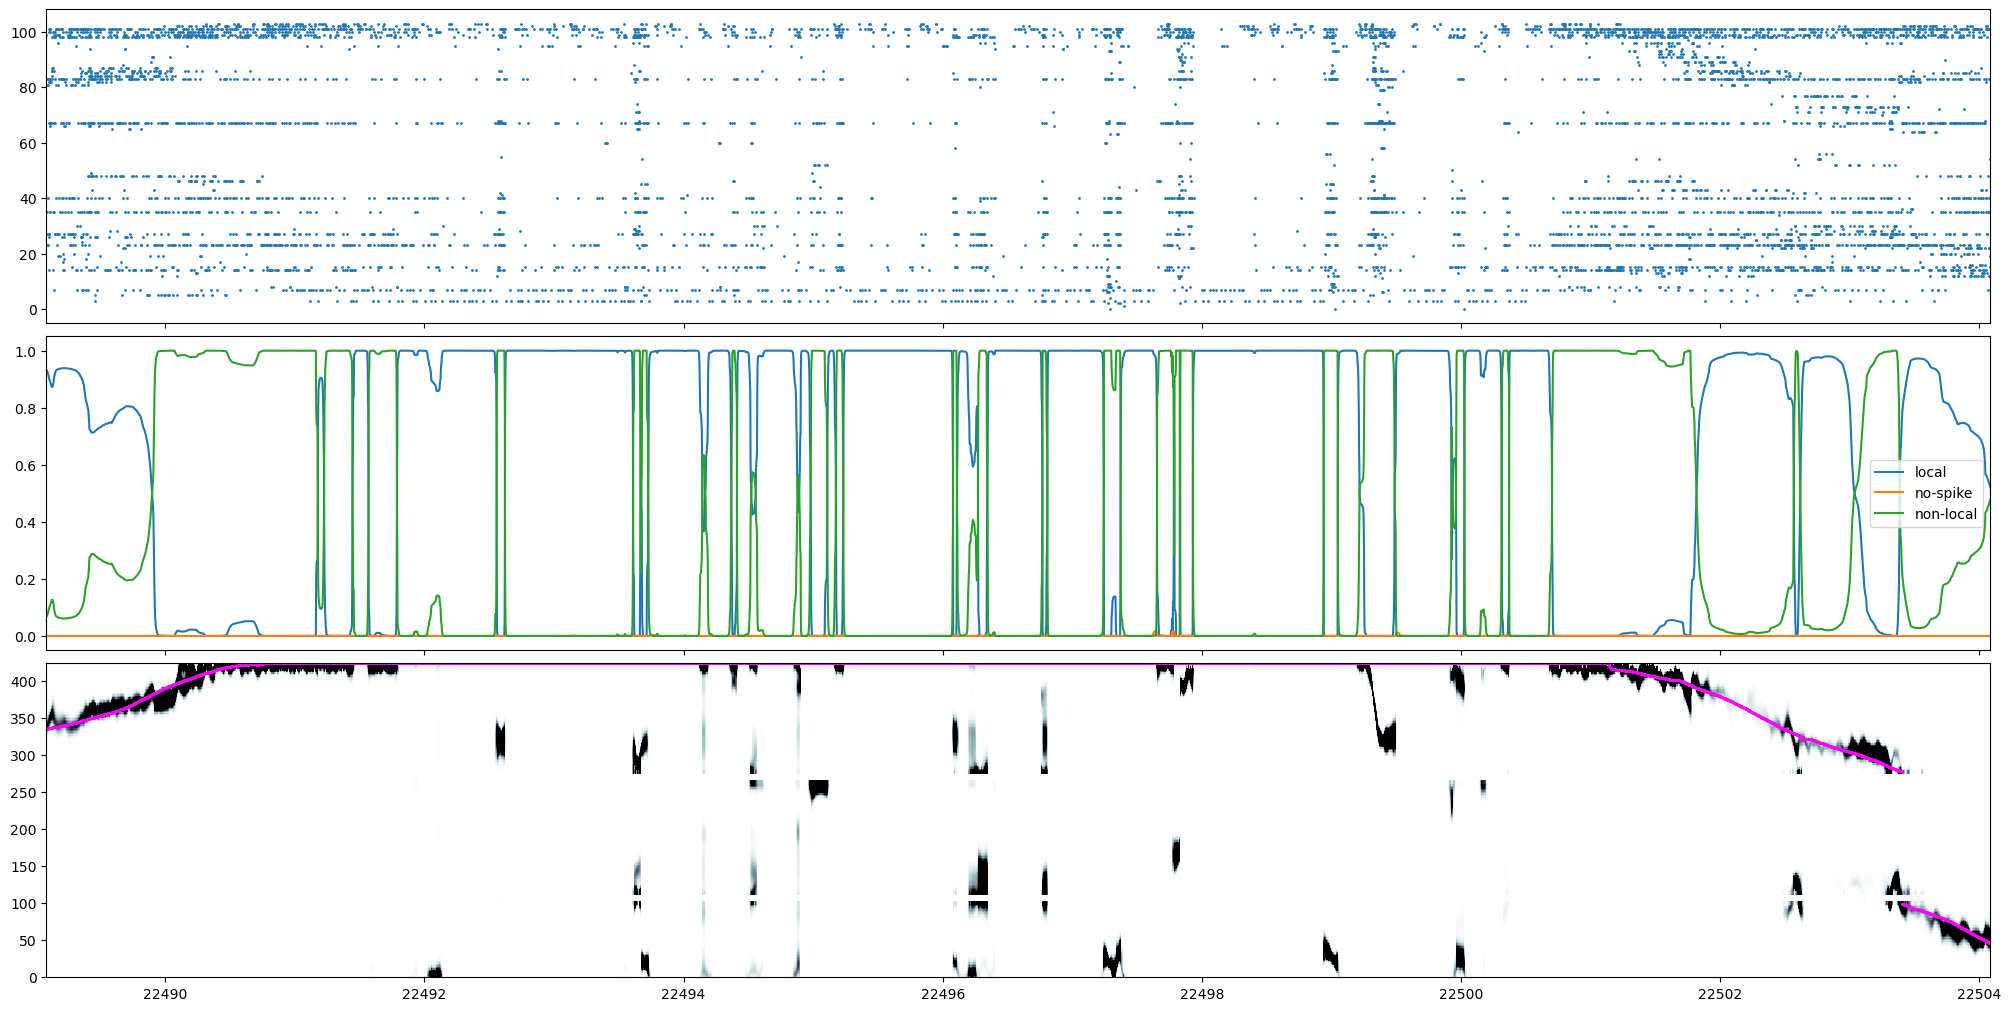

In [7]:
time = position_info.index / np.timedelta64(1, "s")
neuron_sort_ind = np.argsort(env.place_bin_centers_[non_local_rates.argmax(axis=0)].squeeze())

t,x = np.meshgrid(time, env.place_bin_centers_)

fig, axes = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(20, 10))

spike_time_ind, neuron_ind = np.nonzero(spikes[:, neuron_sort_ind])
axes[0].scatter(time[spike_time_ind], neuron_ind, s=1)
h = axes[1].plot(time, acausal_state_probabilities)
axes[1].legend(h, ["local", "no-spike", "non-local"])
axes[2].pcolormesh(t,x, acausal_posterior[:, state_ind == 2].T, vmin=0.0, vmax=0.01, cmap="bone_r")
axes[2].scatter(time, position, s=1, color="magenta", zorder=2)
plt.xlim((time.min() + 100, time.min() + 115))


(22499.082875307, 22509.082875307)

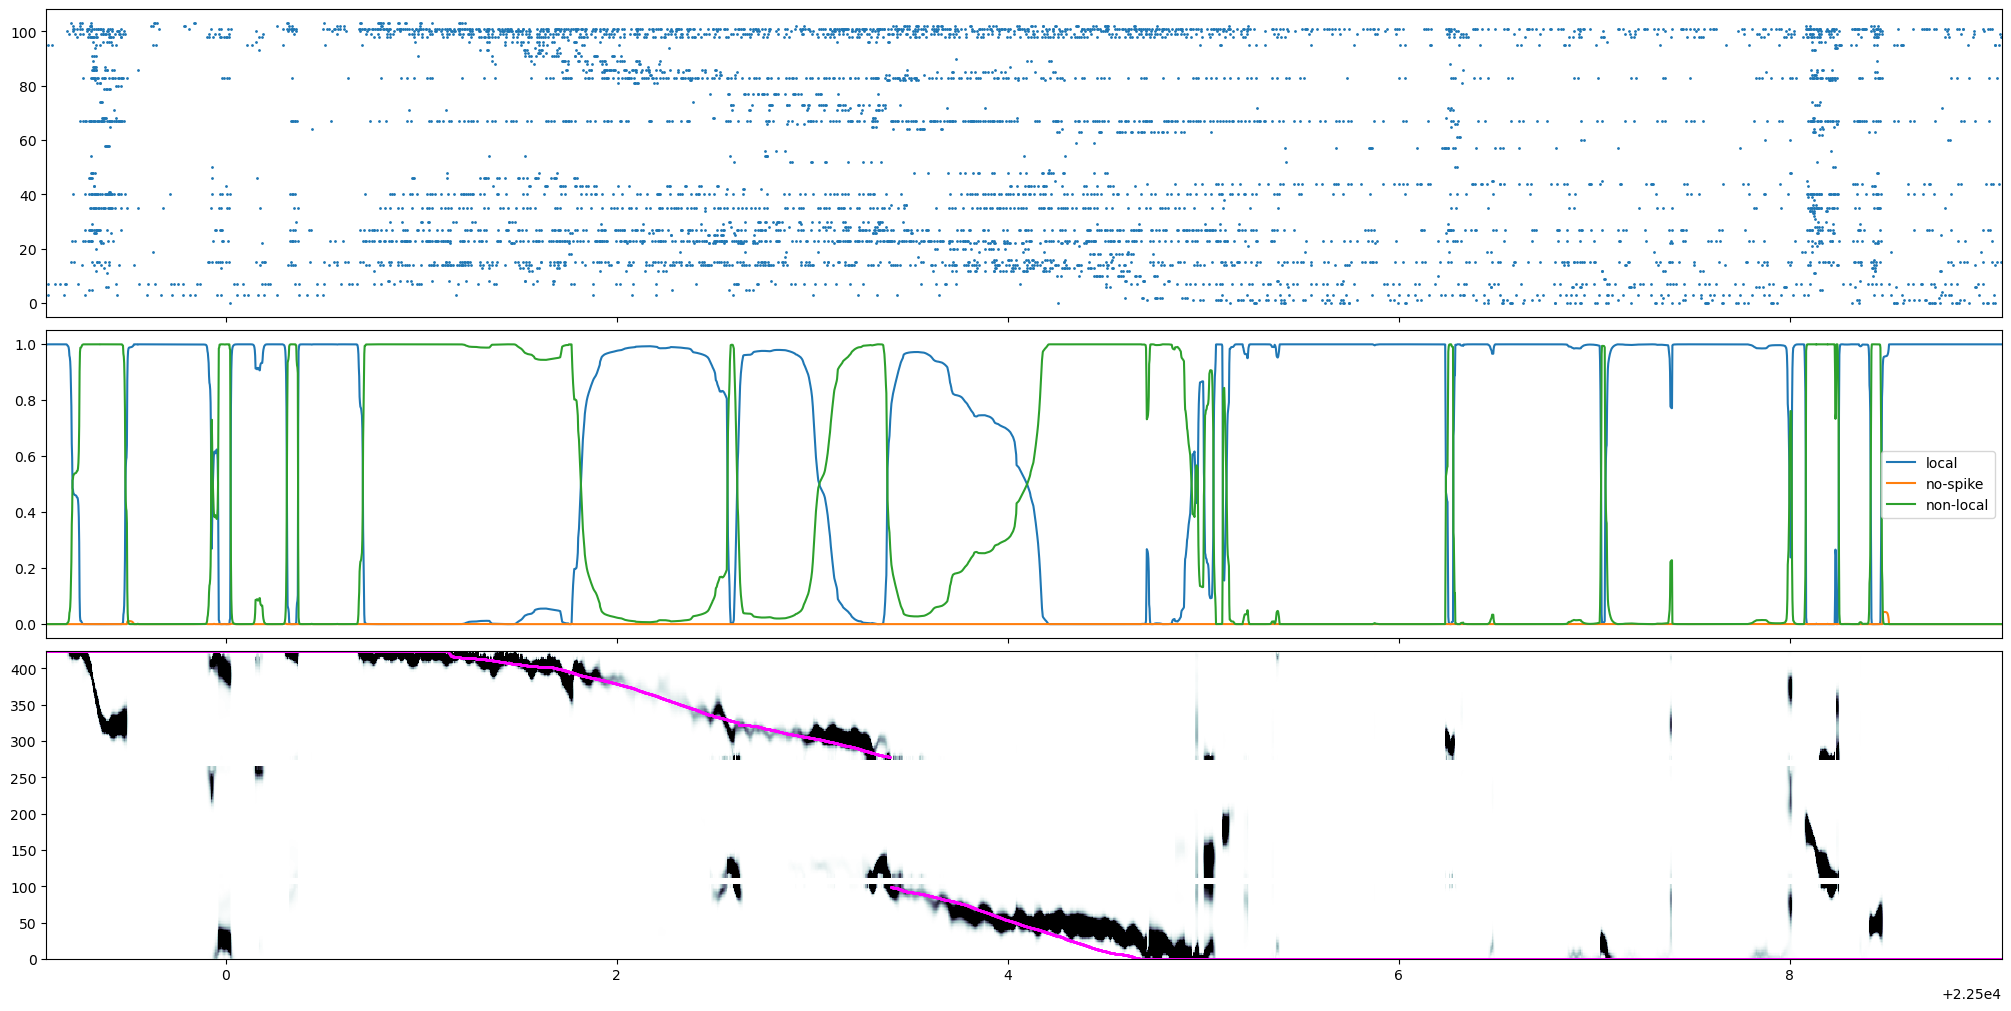

In [8]:
time = position_info.index / np.timedelta64(1, "s")
neuron_sort_ind = np.argsort(env.place_bin_centers_[non_local_rates.argmax(axis=0)].squeeze())

t,x = np.meshgrid(time, env.place_bin_centers_)

fig, axes = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(20, 10))

spike_time_ind, neuron_ind = np.nonzero(spikes[:, neuron_sort_ind])
axes[0].scatter(time[spike_time_ind], neuron_ind, s=1)
h = axes[1].plot(time, acausal_state_probabilities)
axes[1].legend(h, ["local", "no-spike", "non-local"])
axes[2].pcolormesh(t,x, acausal_posterior[:, state_ind == 2].T, vmin=0.0, vmax=0.01, cmap="bone_r")
axes[2].scatter(time, position, s=1, color="magenta", zorder=2)
plt.xlim((time.min() + 110, time.min() + 120))


(22519.082875307, 22539.082875307)

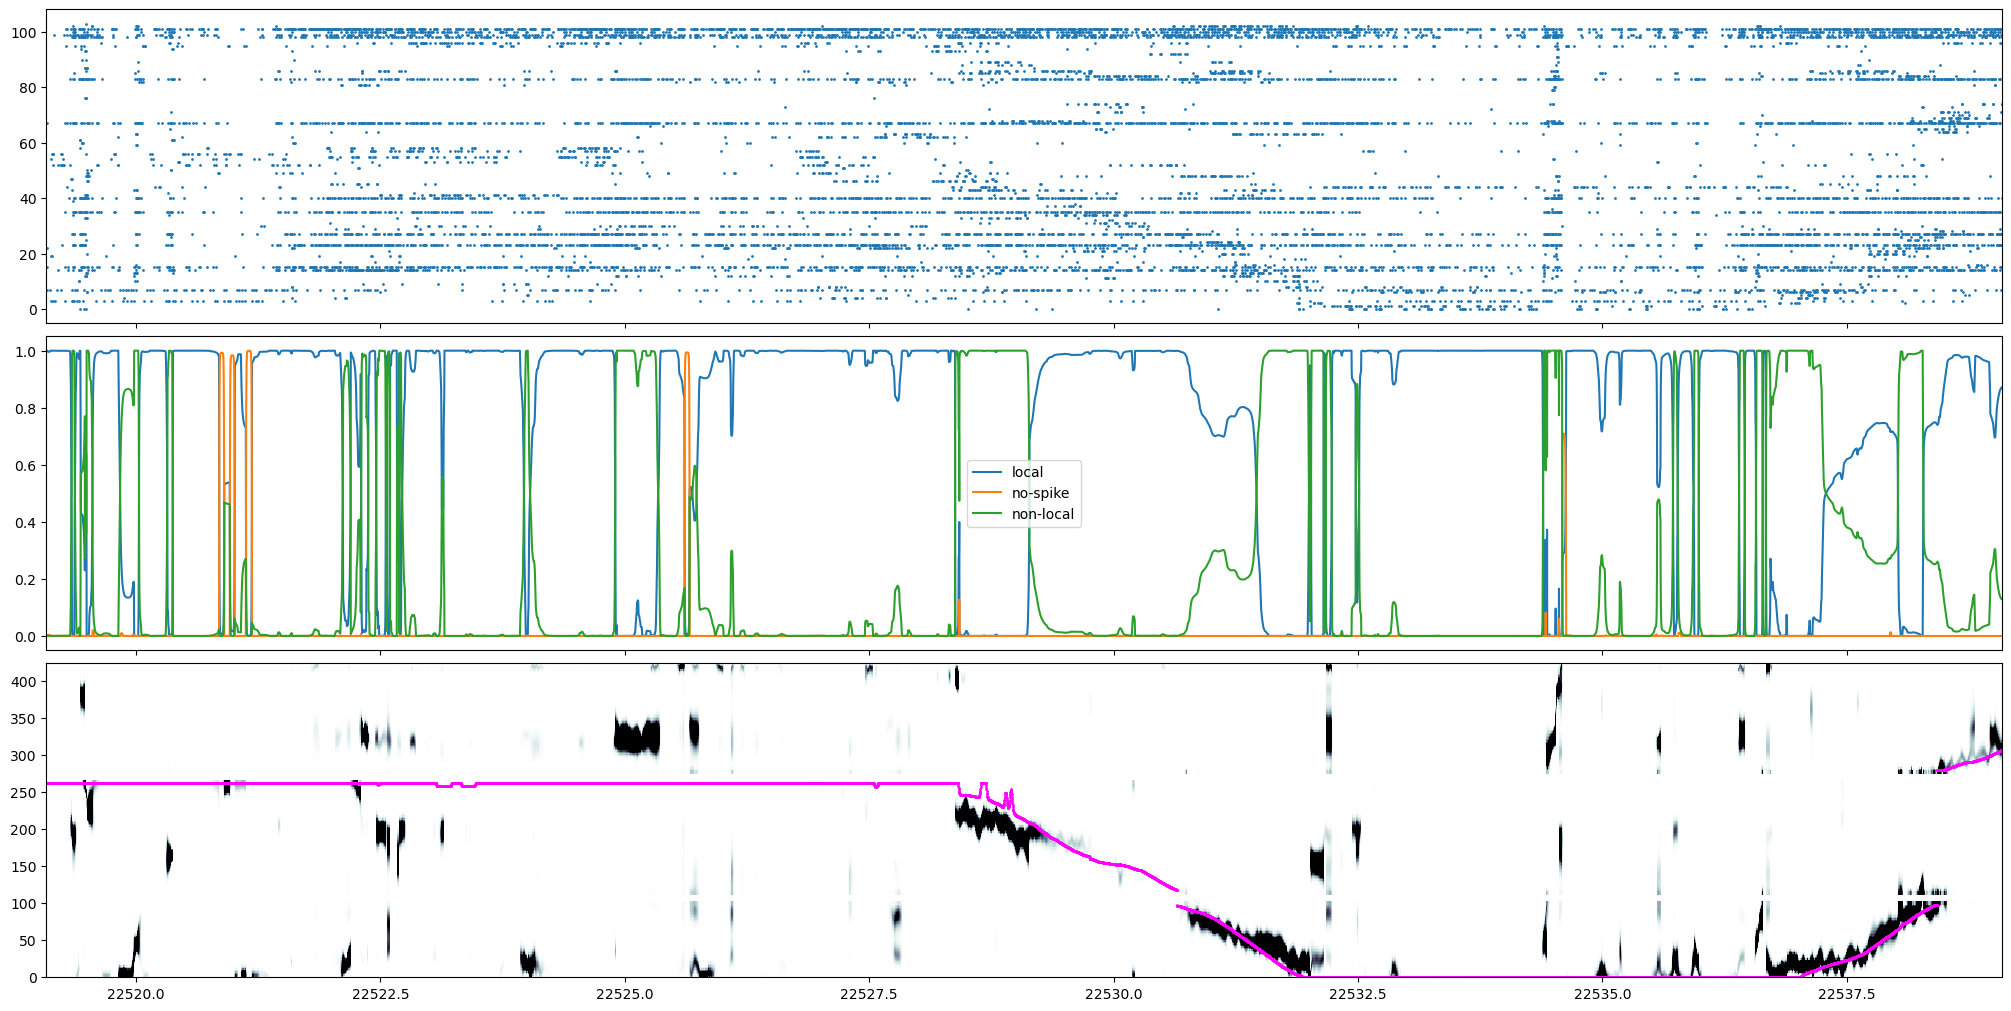

In [9]:
time = position_info.index / np.timedelta64(1, "s")
neuron_sort_ind = np.argsort(env.place_bin_centers_[non_local_rates.argmax(axis=0)].squeeze())

t,x = np.meshgrid(time, env.place_bin_centers_)

fig, axes = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(20, 10))

spike_time_ind, neuron_ind = np.nonzero(spikes[:, neuron_sort_ind])
axes[0].scatter(time[spike_time_ind], neuron_ind, s=1)
h = axes[1].plot(time, acausal_state_probabilities)
axes[1].legend(h, ["local", "no-spike", "non-local"])
axes[2].pcolormesh(t,x, acausal_posterior[:, state_ind == 2].T, vmin=0.0, vmax=0.01, cmap="bone_r")
axes[2].scatter(time, position, s=1, color="magenta", zorder=2)
plt.xlim((time.min() + 130, time.min() + 150))


(22539.082875307, 22559.082875307)

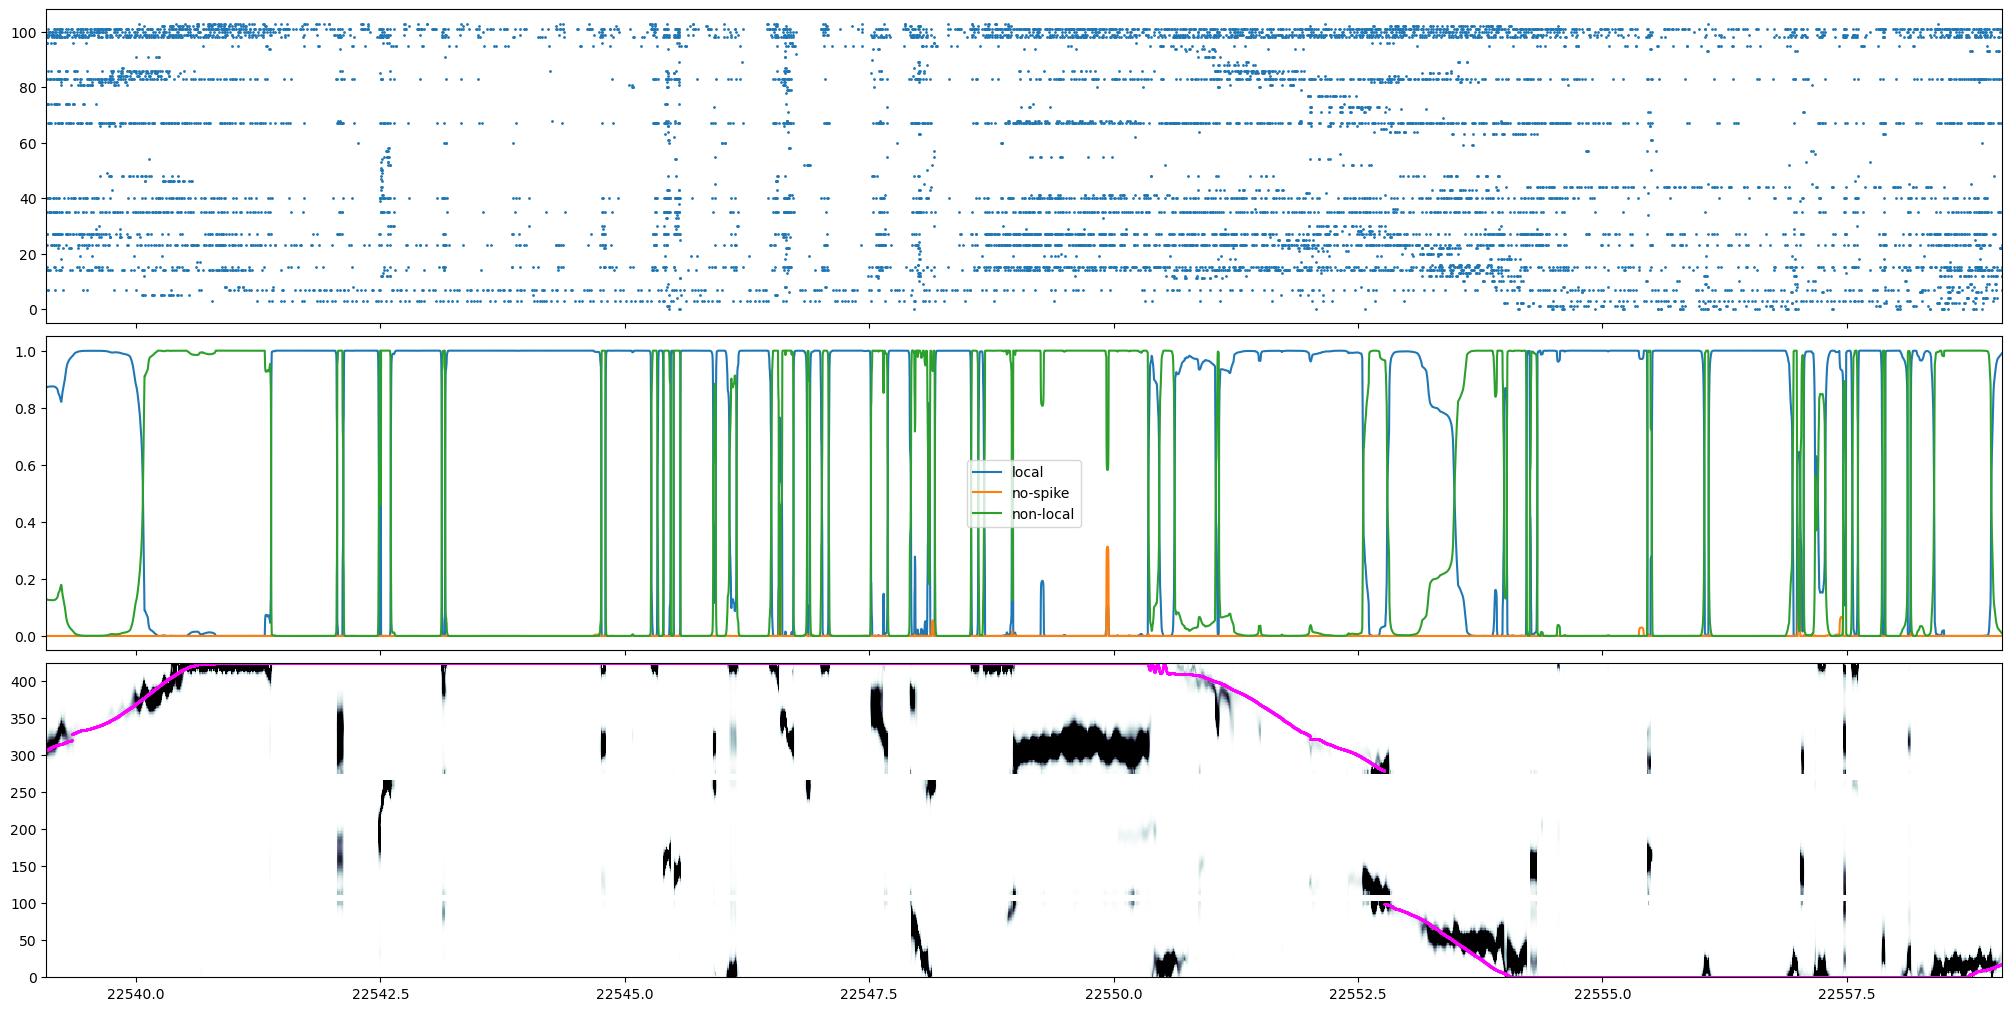

In [10]:
time = position_info.index / np.timedelta64(1, "s")
neuron_sort_ind = np.argsort(env.place_bin_centers_[non_local_rates.argmax(axis=0)].squeeze())

t,x = np.meshgrid(time, env.place_bin_centers_)

fig, axes = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(20, 10))

spike_time_ind, neuron_ind = np.nonzero(spikes[:, neuron_sort_ind])
axes[0].scatter(time[spike_time_ind], neuron_ind, s=1)
h = axes[1].plot(time, acausal_state_probabilities)
axes[1].legend(h, ["local", "no-spike", "non-local"])
axes[2].pcolormesh(t,x, acausal_posterior[:, state_ind == 2].T, vmin=0.0, vmax=0.01, cmap="bone_r")
axes[2].scatter(time, position, s=1, color="magenta", zorder=2)
plt.xlim((time.min() + 150, time.min() + 170))


(22559.082875307, 22579.082875307)

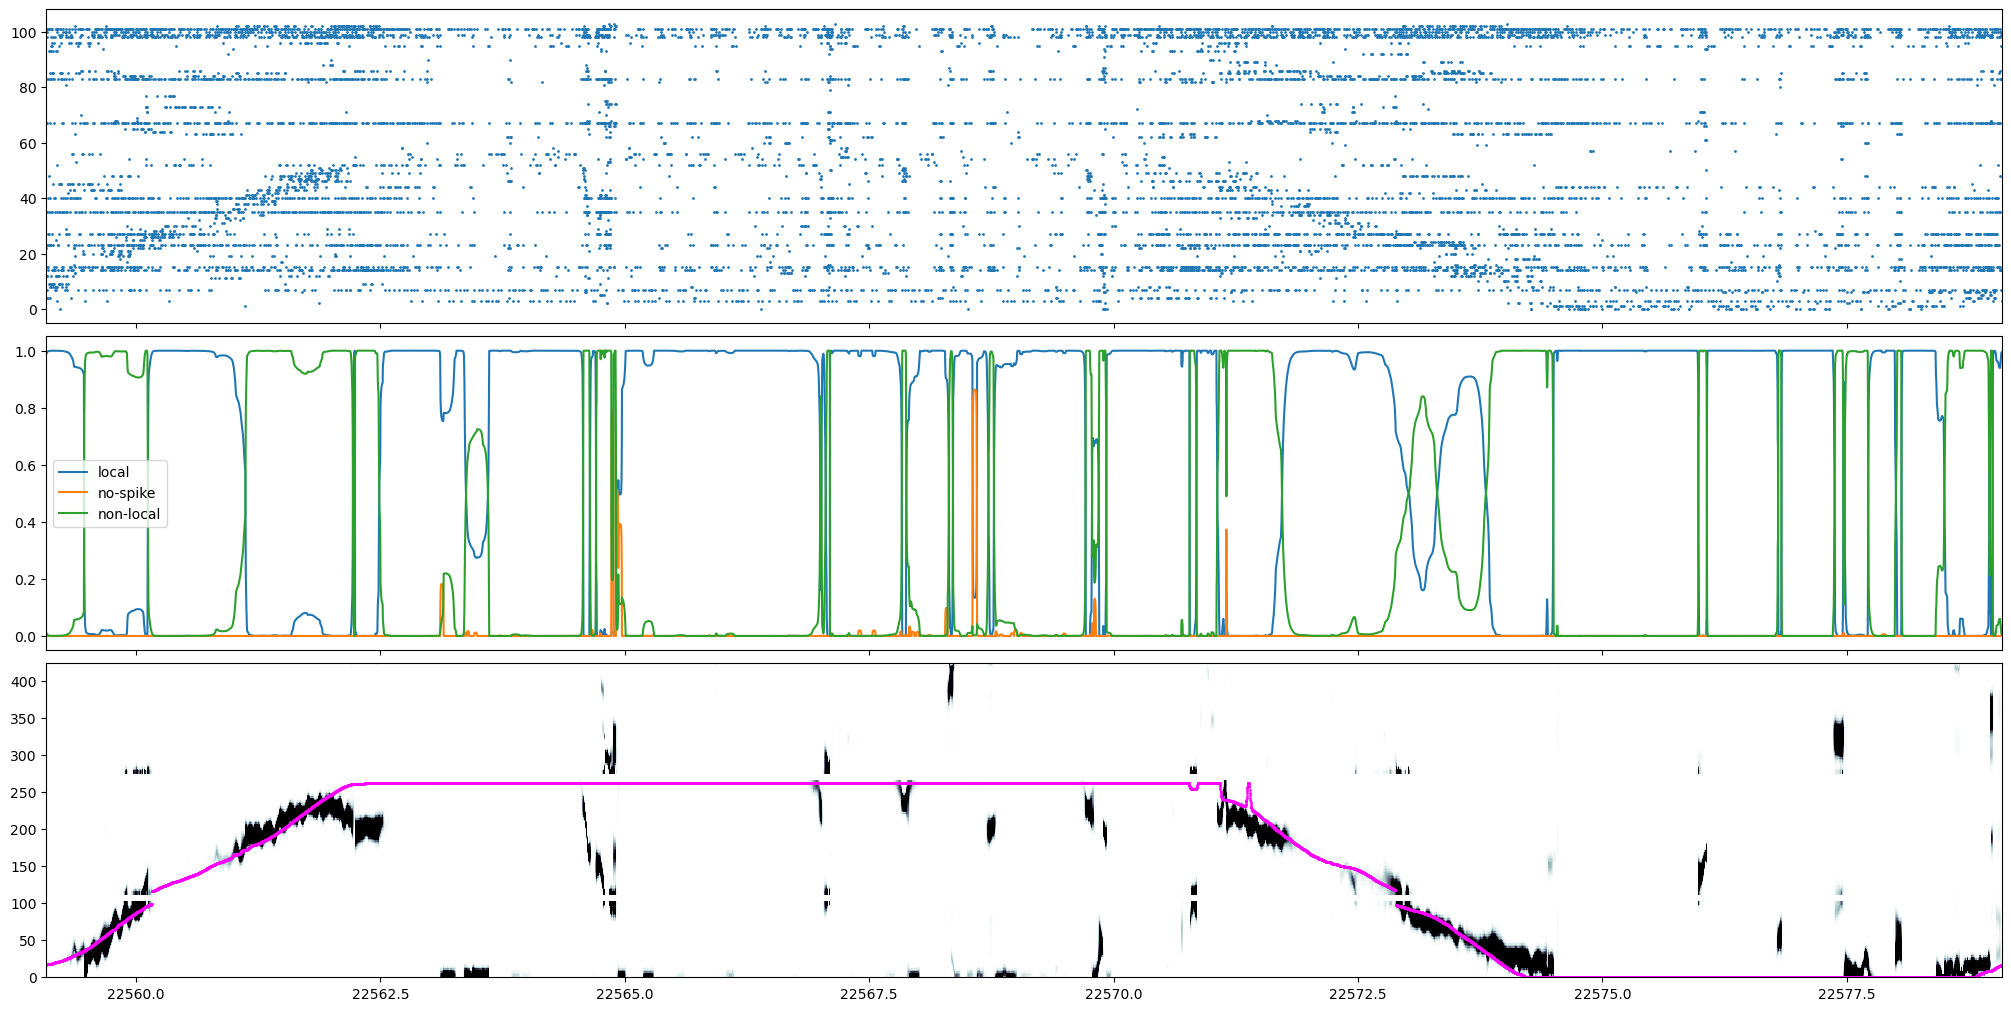

In [11]:
time = position_info.index / np.timedelta64(1, "s")
neuron_sort_ind = np.argsort(env.place_bin_centers_[non_local_rates.argmax(axis=0)].squeeze())

t,x = np.meshgrid(time, env.place_bin_centers_)

fig, axes = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(20, 10))

spike_time_ind, neuron_ind = np.nonzero(spikes[:, neuron_sort_ind])
axes[0].scatter(time[spike_time_ind], neuron_ind, s=1)
h = axes[1].plot(time, acausal_state_probabilities)
axes[1].legend(h, ["local", "no-spike", "non-local"])
axes[2].pcolormesh(t,x, acausal_posterior[:, state_ind == 2].T, vmin=0.0, vmax=0.01, cmap="bone_r")
axes[2].scatter(time, position, s=1, color="magenta", zorder=2)
plt.xlim((time.min() + 170, time.min() + 190))


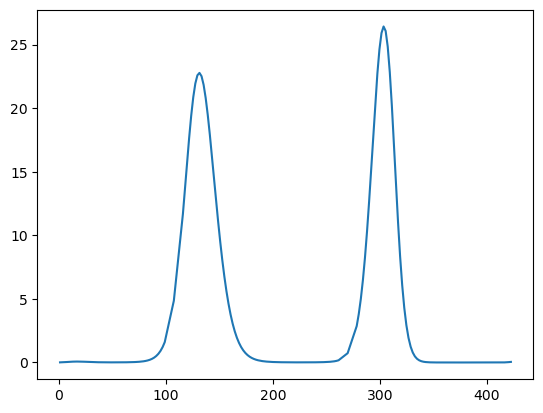

In [12]:
plt.plot(env.place_bin_centers_, non_local_rates[:,5] * sampling_frequency)

In [13]:
discrete_state_transitions[0,0]

0.9995433635120319

In [14]:
discrete_state_transitions[1,1]

0.9999

In [15]:
discrete_state_transitions[2,2]

0.98

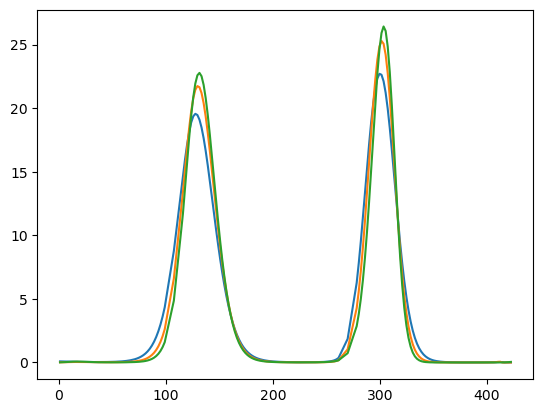

In [17]:
for r in non_local_rates_iter:
    plt.plot(env.place_bin_centers_, r[:,5] * sampling_frequency)

(22559.082875307, 22569.082875307)

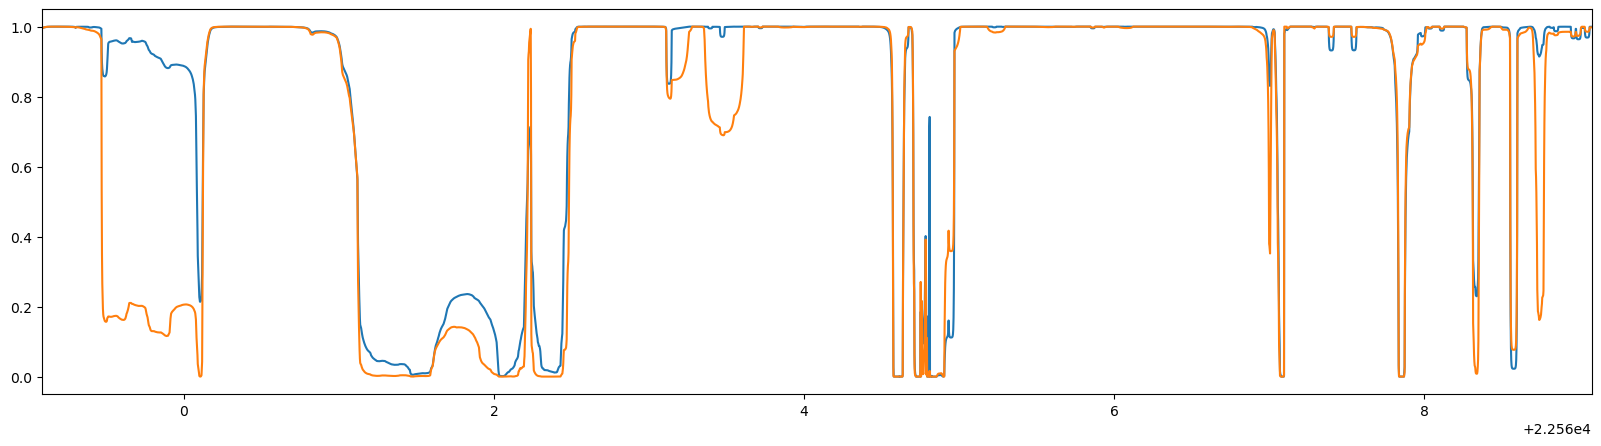

In [22]:
plt.figure(figsize=(20, 5))
for it in is_training_iter[1:]:
    plt.plot(time, it)
    
plt.xlim((time.min() + 170, time.min() + 180))

In [33]:
np.argmax(np.abs(coefficients_iter[1] - coefficients_iter[2]), axis=1)

array([ 81,   0,   0,  81,  10, 103,  12,  13,  81,  81,  81,  81,  74,
        58,   0,   0])

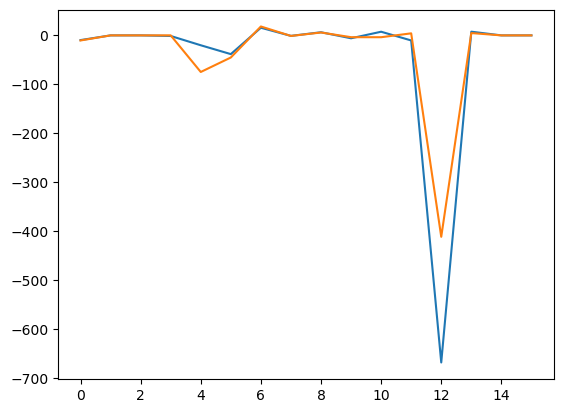

In [68]:
neuron_ind = 10
plt.plot(coefficients_iter[1][:, neuron_ind])
plt.plot(coefficients_iter[2][:, neuron_ind])

In [53]:
np.exp(coefficients_iter[2][:, neuron_ind])

array([9.61520074e-04, 1.00000000e+00, 1.00000000e+00, 2.94302001e-01,
       1.35990043e+00, 7.26207143e-02, 6.33383716e-01, 5.29957603e-02,
       3.74871030e+00, 8.12412013e-01, 1.09431730e-06, 5.01083197e+21,
       0.00000000e+00, 7.96723875e+10, 1.00000000e+00, 1.00000000e+00])

In [63]:
[nl[:, neuron_ind].max() * sampling_frequency for nl in non_local_rates_iter]

[array(1.88647159), array(2.20231878), array(2.35572739)]

In [64]:
spikes[:, neuron_ind].sum()

221

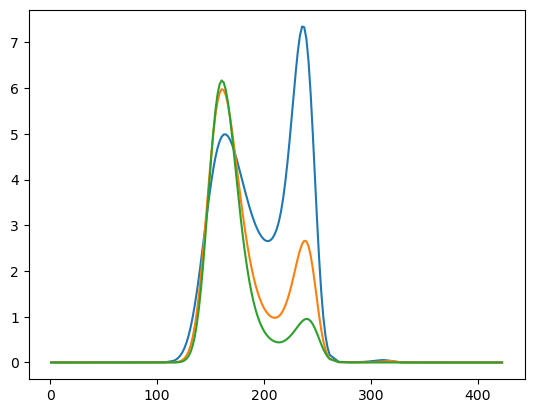

In [69]:
for r in non_local_rates_iter:
    plt.plot(env.place_bin_centers_, r[:,neuron_ind] * sampling_frequency)

In [ ]:
# remove neuron 81 and refit?